In [ ]:
# BASELINE MODEL
# MC Classifier + Logistic Regression

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')


In [35]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [116]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df_train = pd.read_csv("adult/adult.data", header=None, names=column_names)
df_test = pd.read_csv('adult/adult.test', header=None, names=column_names, skiprows=1)
print("Training data shape:", df_train.shape)
print("Testing data shape:", df_test.shape)
print(f'{df_train.info()}')

Training data shape: (32561, 15)
Testing data shape: (16281, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [44]:
print(f'First 5 rows of training data:\n{df_train.head()}')
print(df_train['income'].value_counts())
print(df_test['income'].value_counts())

First 5 rows of training data:
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0        

In [118]:
def clean_adult_data(df):
    df = df.copy()
    df['income'] = (
        df['income']
        .str.strip()
        .str.replace('.', '', regex=False)
        .str.lower()
    )
    df.replace('?', np.nan, inplace=True)
    return df

df_train = clean_adult_data(df_train)
df_test = clean_adult_data(df_test)

print(df_train.isnull().sum())
print(df_test.isnull().sum())
print(df_train['income'].unique())


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
['<=50k' '>50k']


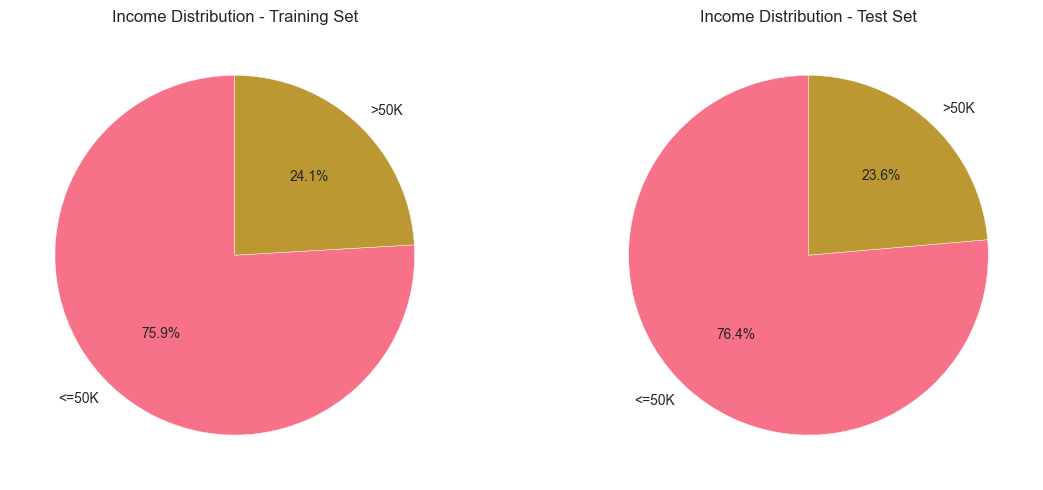

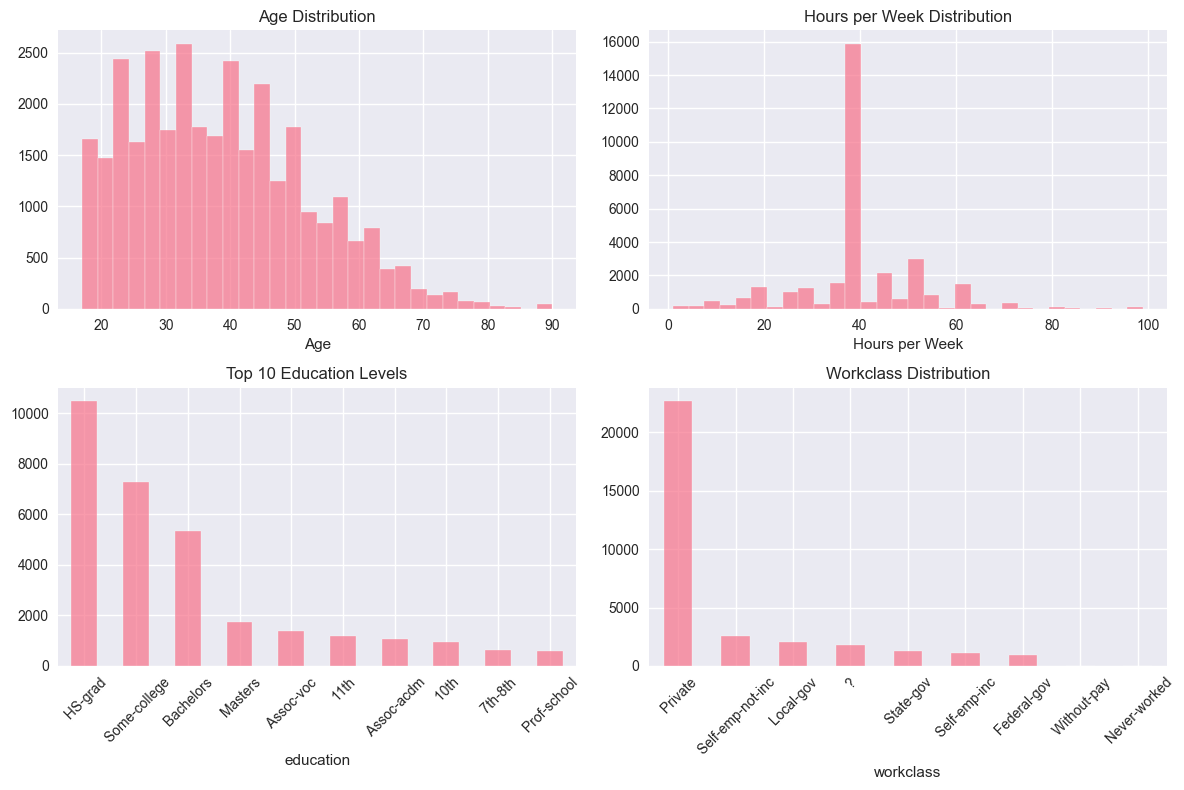

In [49]:
# Visualizating key distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

train_income_counts = df_train['income'].value_counts()
ax1.pie(train_income_counts.values, labels=train_income_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Income Distribution - Training Set')

test_income_counts = df_test['income'].value_counts()
ax2.pie(test_income_counts.values, labels=test_income_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Income Distribution - Test Set')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df_train['age'].hist(bins=30, ax=axes[0,0], alpha=0.7)
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')

df_train['hours-per-week'].hist(bins=30, ax=axes[0,1], alpha=0.7)
axes[0,1].set_title('Hours per Week Distribution')
axes[0,1].set_xlabel('Hours per Week')

df_train['education'].value_counts().head(10).plot(kind='bar', ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Top 10 Education Levels')
axes[1,0].tick_params(axis='x', rotation=45)

df_train['workclass'].value_counts().plot(kind='bar', ax=axes[1,1], alpha=0.7)
axes[1,1].set_title('Workclass Distribution')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
X_train = df_train.drop('income', axis=1)
y_train = df_train['income']
X_test = df_test.drop('income', axis=1)
y_test = df_test['income']
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (32561, 14), y_train shape: (32561,)
X_test shape: (16281, 14), y_test shape: (16281,)


In [ ]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                        'race','sex', 'native-country']
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                      'capital-loss', 'hours-per-week']

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', ))
])
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

X_train_pr = preprocessor.fit_transform(X_train)
X_test_pr = preprocessor.transform(X_test)
print(f'Preprocessed X_train shape: {X_train_pr.shape}')
print(f'Preprocessed X_test shape: {X_test_pr.shape}')


Preprocessed X_train shape: (32561, 108)
Preprocessed X_test shape: (16281, 108)


In [72]:
store_results = {}

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_pr = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    store_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': class_report['>50k']['precision'],
        'recall': class_report['>50k']['recall'],
        'f1-score': class_report['>50k']['f1-score'],
        'roc_auc': roc_auc_score(y_test.map({'<=50k': 0, '>50k': 1}), y_pred_pr) if y_pred_pr is not None else None,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision:: {class_report['>50k']['precision']:.4f}")
    print(f"Recall: {class_report['>50k']['recall']:.4f}")
    print(f"F1-Score: {class_report['>50k']['f1-score']:.4f}")
    if y_pred_pr is not None:
        print(f"ROC AUC: {store_results[model_name]['roc_auc']:.4f}")
    print("Confusion Matrix:")
    print(store_results[model_name]['confusion_matrix'])
    print("\n")
    
    return store_results[model_name]

print("\n--- Dummy Classifier (Majority Class) ---")
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dc_results = evaluate_model(dummy_clf, X_train_pr, y_train, X_test_pr, y_test, "Dummy Classifier")
print(f"DummyClassifier predicts all samples as: {dummy_clf.predict(X_test_pr)[0]}")
print(f"Baseline accuracy (majority class %): {(y_test == '<=50k').mean():.4f}\n")



--- Dummy Classifier (Majority Class) ---
Model: Dummy Classifier
Accuracy: 0.7638
Precision:: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC AUC: 0.5000
Confusion Matrix:
[[12435     0]
 [ 3846     0]]


DummyClassifier predicts all samples as: <=50k
Baseline accuracy (majority class %): 0.7638



In [74]:
# Logistic Regression
print("\n--- Logistic Regression ---")

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, C=1.0, random_state=42)
lr_results = evaluate_model(lr_model, X_train_pr, y_train, X_test_pr, y_test, "Logistic Regression")

df_results = pd.DataFrame.from_dict(store_results, orient='index')
df_results = df_results[['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc']]
df_results = df_results.round(4)

print("Model Performance Summary:")
display(df_results)


--- Logistic Regression ---
Model: Logistic Regression
Accuracy: 0.8092
Precision:: 0.5646
Recall: 0.8404
F1-Score: 0.6754
ROC AUC: 0.9053
Confusion Matrix:
[[9943 2492]
 [ 614 3232]]


Model Performance Summary:


,accuracy,precision,recall,f1-score,roc_auc
Dummy Classifier,0.7638,0.0000,0.0000,0.0000,0.5000
Logistic Regression,0.8092,0.5646,0.8404,0.6754,0.9053


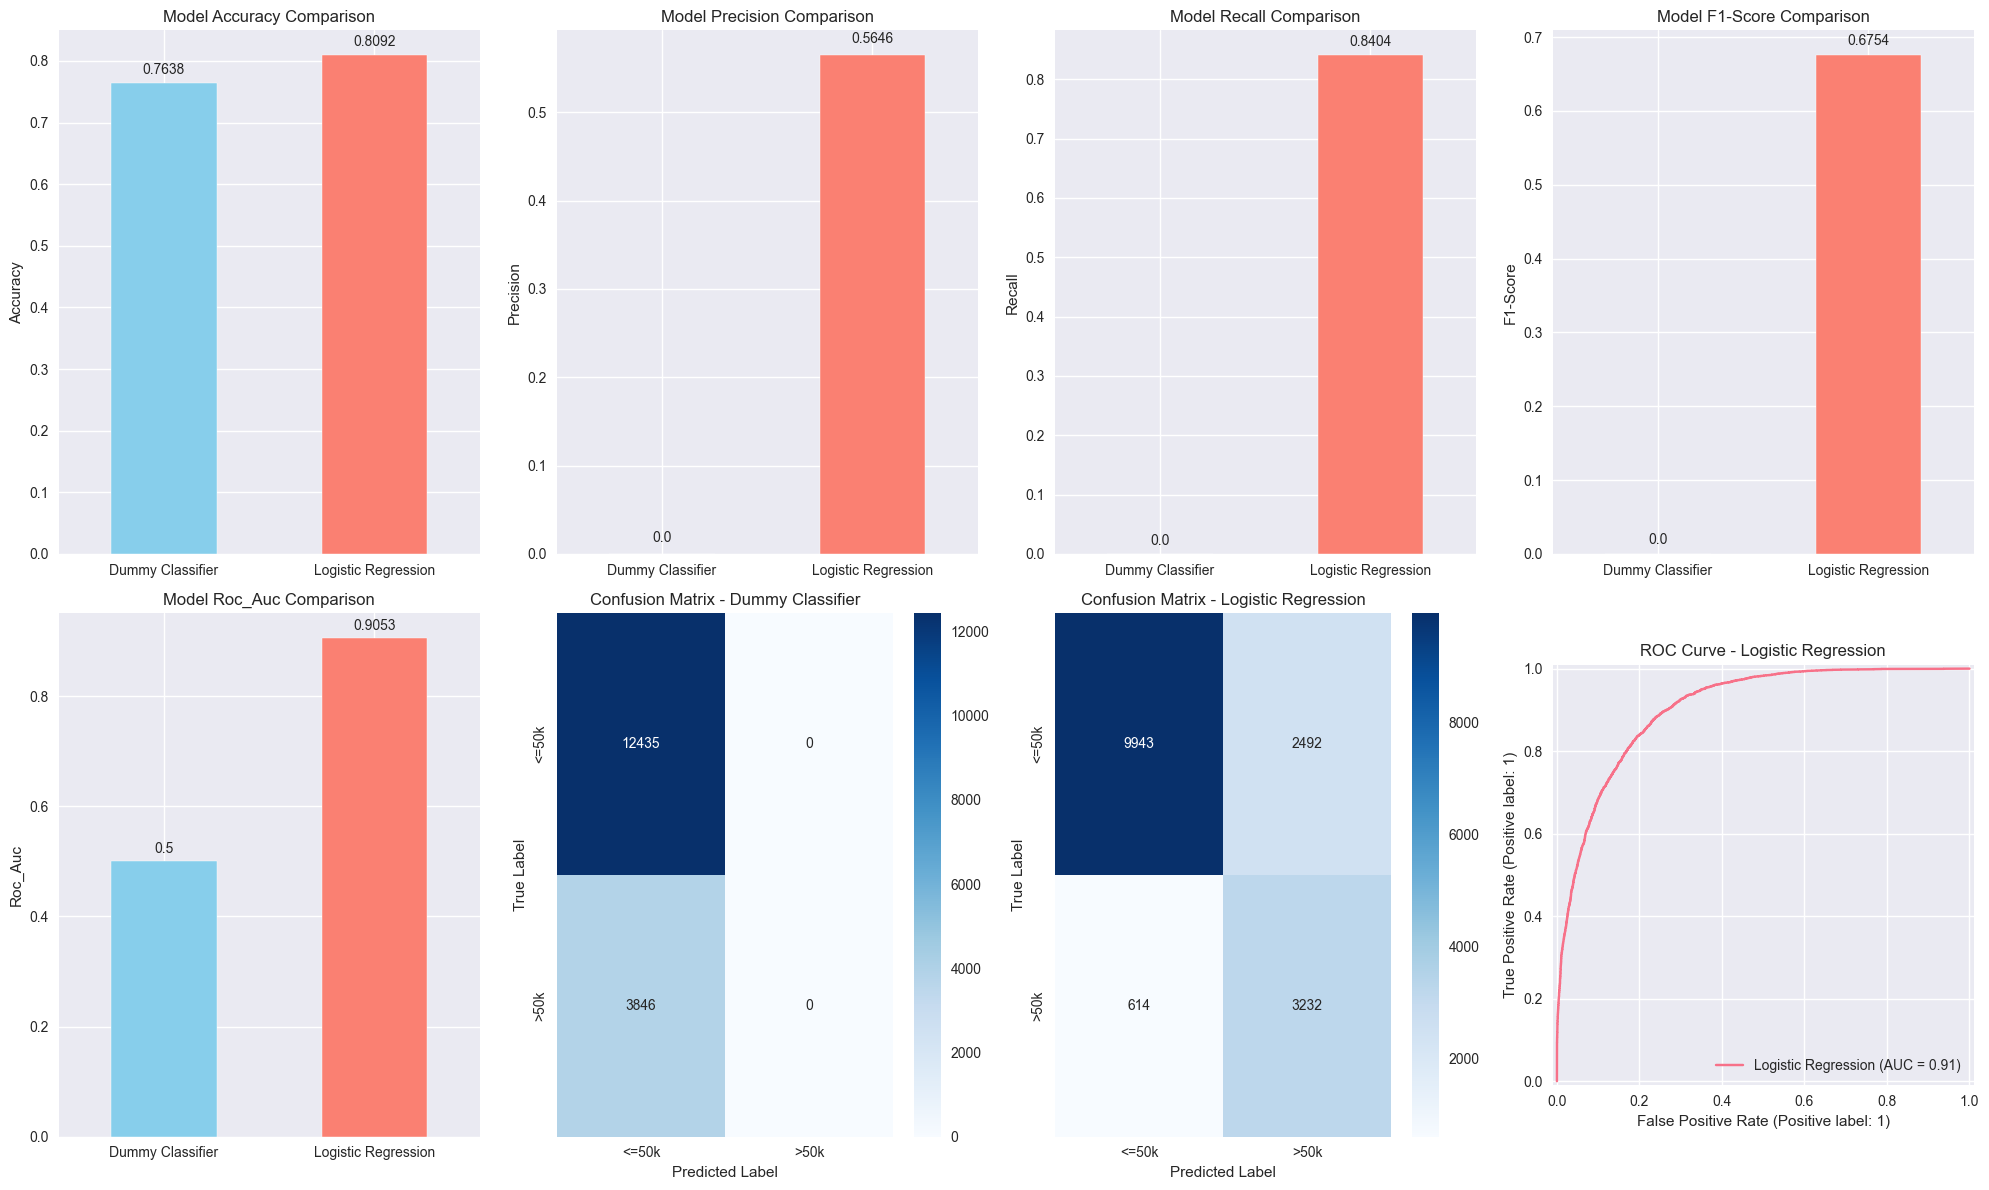

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
metrics = ['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc']
for i, metric in enumerate(metrics):
    df_results[metric].plot(kind='bar', ax=axes.flat[i], color=['skyblue', 'salmon'])
    axes.flat[i].set_title(f"Model {metric.title()} Comparison")
    axes.flat[i].set_ylabel(metric.title())
    axes.flat[i].tick_params(axis='x', rotation=0)

    for j, v in enumerate(df_results[metric]):
        axes.flat[i].text(j, v + 0.01, str(v), ha='center', va='bottom')

plot_model = ["Dummy Classifier", "Logistic Regression"]
for i, model_name in enumerate(plot_model):
    cm = store_results[model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['<=50k', '>50k'], yticklabels=['<=50k', '>50k'], ax=axes.flat[i+5])
    axes.flat[i+5].set_title(f'Confusion Matrix - {model_name}')
    axes.flat[i+5].set_xlabel('Predicted Label')
    axes.flat[i+5].set_ylabel('True Label')

lr_model = store_results["Logistic Regression"]["model"]
y_pred_pr = lr_model.predict_proba(X_test_pr)[:, 1]

RocCurveDisplay.from_predictions(
    y_test.map({'<=50k': 0, '>50k': 1}),
    y_pred_pr,
    ax=axes.flat[7],
    name="Logistic Regression"
)
axes.flat[7].set_title("ROC Curve - Logistic Regression")

plt.tight_layout()
plt.show()
    

In [93]:
# feature names after preprocessing
ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numerical_features, ohe_feature_names])
print(f'Feature names after preprocessing: {feature_names}')
print(f'Preprocessed feature names count: {len(feature_names)}')


Feature names after preprocessing: ['age' 'fnlwgt' 'education-num' 'capital-gain' 'capital-loss'
 'hours-per-week' 'workclass_ ?' 'workclass_ Federal-gov'
 'workclass_ Local-gov' 'workclass_ Never-worked' 'workclass_ Private'
 'workclass_ Self-emp-inc' 'workclass_ Self-emp-not-inc'
 'workclass_ State-gov' 'workclass_ Without-pay' 'education_ 10th'
 'education_ 11th' 'education_ 12th' 'education_ 1st-4th'
 'education_ 5th-6th' 'education_ 7th-8th' 'education_ 9th'
 'education_ Assoc-acdm' 'education_ Assoc-voc' 'education_ Bachelors'
 'education_ Doctorate' 'education_ HS-grad' 'education_ Masters'
 'education_ Preschool' 'education_ Prof-school' 'education_ Some-college'
 'marital-status_ Divorced' 'marital-status_ Married-AF-spouse'
 'marital-status_ Married-civ-spouse'
 'marital-status_ Married-spouse-absent' 'marital-status_ Never-married'
 'marital-status_ Separated' 'marital-status_ Widowed' 'occupation_ ?'
 'occupation_ Adm-clerical' 'occupation_ Armed-Forces'
 'occupation_ Craft

In [95]:
lr_coefficients = lr_model.coef_[0]
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coefficients,
    'abs_Coefficient': np.abs(lr_coefficients)
})

top_features = coef_df.nlargest(10, 'abs_Coefficient')[['Feature', 'Coefficient']]
print("Top 10 Features Influencing Income Prediction:")
display(top_features)

Top 10 Features Influencing Income Prediction:


,Feature,Coefficient
3,capital-gain,2.343424
47,occupation_ Priv-house-serv,-1.959347
32,marital-status_ Married-AF-spouse,1.904656
70,native-country_ Columbia,-1.568080
33,marital-status_ Married-civ-spouse,1.456432
35,marital-status_ Never-married,-1.200766
72,native-country_ Dominican-Republic,-1.188428
58,relationship_ Wife,1.113119
67,native-country_ Cambodia,1.088356
14,workclass_ Without-pay,-1.007092


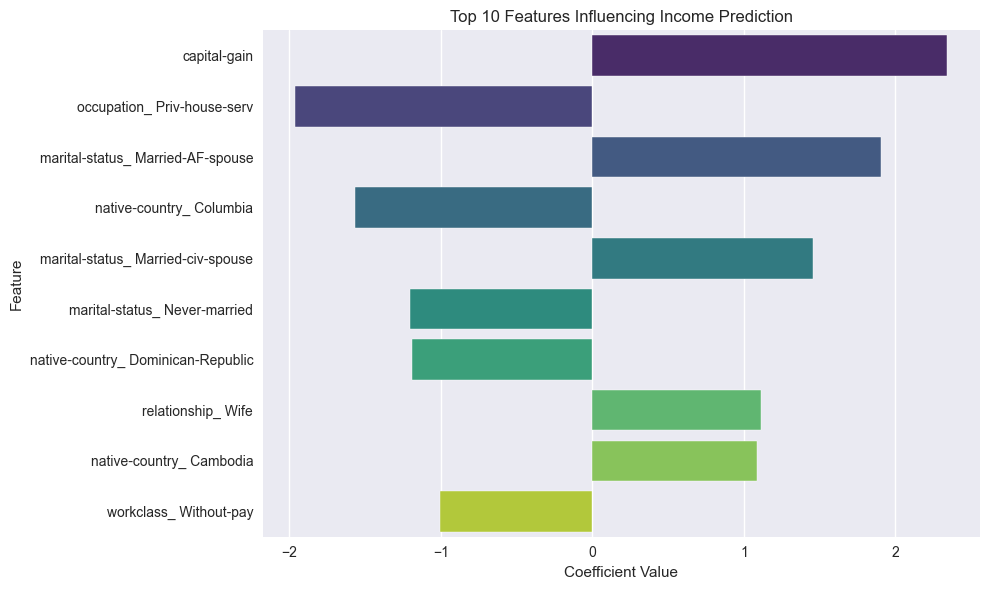

In [96]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Features Influencing Income Prediction')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [119]:
# Cross-validation Results
models = {
    "Dummy Classifier": dummy_clf,
    "Logistic Regression": lr_model
}
train_results = {}
cv_results = {}
for model_name, model in models.items():
    model.fit(X_train_pr, y_train)
    train_accuracy = model.score(X_train_pr, y_train)
    train_results[model_name] = train_accuracy
    cv_accuracy = cross_val_score(model, X_train_pr, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_results[model_name] = cv_accuracy
    print(f"{model_name}: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std() * 2:.4f})")
    print(f"{model_name}: Train={train_accuracy:.4f},  Val={cv_accuracy.mean():.4f}")


Dummy Classifier: 0.7592 (+/- 0.0001)
Dummy Classifier: Train=0.7592,  Val=0.7592
Logistic Regression: 0.8118 (+/- 0.0084)
Logistic Regression: Train=0.8129,  Val=0.8118


Logistic Regression achieved a cross-validation accuracy of 0.8118 (+/- 0.0084), outperforming the baseline Dummy Classifier (0.7592 (+/- 0.0001)).

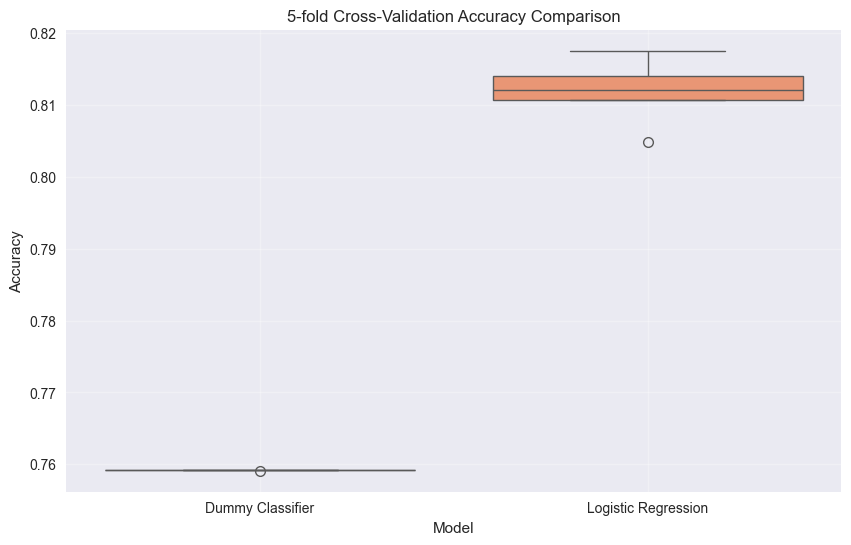

In [108]:
plt.figure(figsize=(10, 6))
df_cv = pd.DataFrame(cv_results)
sns.boxplot(data=df_cv, palette='Set2')
plt.title('5-fold Cross-Validation Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

In [111]:
# Model Summary
print("Baseline Models Performance Summary\n")

dc_acc = df_results.loc['Dummy Classifier', 'accuracy']
lr_acc = df_results.loc['Logistic Regression', 'accuracy']
importance_gain = ((lr_acc - dc_acc) / dc_acc) * 100
print(f"Dummy Classifier Accuracy: {dc_acc:.4f}")
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")
print(f"\nImportance Gain over Baseline: {importance_gain:.2f}%")


Baseline Models Performance Summary

Dummy Classifier Accuracy: 0.7638
Logistic Regression Accuracy: 0.8092

Importance Gain over Baseline: 5.94%


In [115]:
print('\nDetailed Summary:\n')
print('The Dummy Classifier achieves 76.38% accuracy by predicting all cases as low-income, but fails to identify any \nhigh-income individuals (Precision=0, Recall=0, AUC=0.50). In contrast, Logistic Regression significantly improves income \nclassification accuracy to 80.92% and achieves strong performance for predicting high-income individuals (Precision=55.46%, Recall=84.04%, AUC=0.85). \nCross-validation confirms robust generalization (81.18 ± 0.0084). Feature analysis reveals that higher capital gain and married status promote \nincome above $50K, whereas occupations such as private house services and non-married status reduce that likelihood. \nOverall, Logistic Regression is a meaningful improvement over the baseline, effectively modeling income prediction patterns.')


Detailed Summary:

The Dummy Classifier achieves 76.38% accuracy by predicting all cases as low-income, but fails to identify any 
high-income individuals (Precision=0, Recall=0, AUC=0.50). In contrast, Logistic Regression significantly improves income 
classification accuracy to 80.92% and achieves strong performance for predicting high-income individuals (Precision=55.46%, Recall=84.04%, AUC=0.85). 
Cross-validation confirms robust generalization (81.18 ± 0.0084). Feature analysis reveals that higher capital gain and married status promote 
income above $50K, whereas occupations such as private house services and non-married status reduce that likelihood. 
Overall, Logistic Regression is a meaningful improvement over the baseline, effectively modeling income prediction patterns.
